In [4]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def img_preprocessing(img):
    img = img.resize((img_size,img_size))
    return img

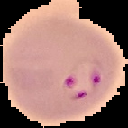

In [6]:
## img_preprocessing 잘 되는지 확인

imgsp=Image.open('./cell_images/parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')
img_size=128
img_preprocessing(imgsp) 

In [8]:
# K-fold cross validation 
# 함수 만드는데는 https://www.kaggle.com/stefanie04736/simple-keras-model-with-k-fold-cross-validation을 주로 참고함. 

import numpy as np
import os
from sklearn.model_selection import KFold

def load_data_kfold(k): 
    dataset_name = 'cell_images'
    channel = 3
    img_list=[]
    img_labels=[]
    for level in ['Parasitized', 'Uninfected'] :
        try : 
            for file in os.listdir('./{}/{}'.format(dataset_name, level)) :
                file_path = './{}/{}/{}'.format(dataset_name,level,file)
                img = Image.open(file_path)
                img_p=img_preprocessing(img)
                img_list.append(np.array(img_p)/255)
    
                if level == 'Parasitized' :
                    label_onehot = np.array([1,0])
                elif level == 'Uninfected':
                    label_onehot = np.array([0,1])      
                img_labels.append(label_onehot)
                       
        except:
            pass  ## thumb.db 등 인식 못하는 경우 생기는 오류 넘기기 위함. 

    imgs=np.array(img_list).reshape(len(img_list),img_size,img_size,channel)
    labels=np.array(img_labels).reshape(len(img_labels),2)
    
    folds = list(KFold(n_splits=k, shuffle=True, random_state=1).split(imgs, labels))
    # KFold.split 으로 트레이닝셋/라벨을 나눴는데.. 이거 맞는건지 잘 모르겠다. 
    # 이렇게 나눠도 imgs-labels 의 관계가 깨지지 않는지를 모르겟음. 
    return folds, imgs, labels

k=5
folds, imgs, labels = load_data_kfold(k)

### 순서 
## 1. load_data_kfold라는 함수를 새로 만들어서 K-fold 데이터를 나눔 
#(일반적으로는 5나 10으로 한다고 함 )
## 2. 함수를 만든 이유는, 각각의 fold마다 train, test의 data와 label을 따로 설정해주기 위함#
# 함수를 새로 만들지 않으면 매 fold마다의 img, labels를 설정하기 어려워짐. 

In [13]:
#Define and Train Model
#지난번에 썼던 모델 그대로 가져옴. 

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

def get_model() :
    model = Sequential()
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(128,128,1)))
    model.add(MaxPooling2D(pool_size=(2, 2))) #(64,64)
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #(32,32)
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #(16,16)
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #(8,8)
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2))) #(4,4)
    model.add(Flatten())
    model.add(Dense(1024, activation='linear'))
    model.add(Dense(2, activation='softmax')) 
    
    adam=keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


Using TensorFlow backend.


In [14]:
model = get_model()
model.summary()

## model 함수를 따로 만들면 굳이 matplotlib을 사용하지 않아도 model 개략 확인 가능


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
__________

In [81]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 5) # 조기종료 콜백함수 정의

for j, (train_idx, val_idx) in enumerate(folds) :
    # for문처럼 반복되는 구간에서 객체가 현재 어느 위치에 있는지 알려주는 인덱스 값이 필요할때 
    # enumerate 함수를 사용하면 매우 유용하다.
    print('\nFold', j)
    train_imgs = imgs[train_idx]
    train_labels = labels[train_idx]
    valid_imgs = imgs[val_idx]
    valid_labels = labels[val_idx]
    
    model = get_model()
    hist= model.fit(train_imgs, train_labels, epochs=20,batch_size=64, 
                    validation_data=(valid_imgs, valid_labels),callbacks=[early_stopping]) 
    
    print("-- Evaluate")
    Eval=model.evaluate(valid_imgs, valid_labels)
    print("%s: %.2f%%" %(model.metrics_names[1], Eval[1]*100))
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()  

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 0.7])

    acc_ax.plot(hist.history['acc'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
    acc_ax.set_ylim([0.5, 1.0])

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()


Fold 0
Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 587s 27ms/step - loss: 0.6376 - acc: 0.6136 - val_loss: 0.3774 - val_acc: 0.8262
Epoch 2/20
22046/22046 [==============================] - 604s 27ms/step - loss: 0.2090 - acc: 0.9216 - val_loss: 0.1992 - val_acc: 0.9283
Epoch 3/20
22046/22046 [==============================] - 607s 28ms/step - loss: 0.1455 - acc: 0.9482 - val_loss: 0.1560 - val_acc: 0.9497
Epoch 4/20
22046/22046 [==============================] - 651s 30ms/step - loss: 0.1326 - acc: 0.9529 - val_loss: 0.1451 - val_acc: 0.9507
Epoch 5/20
22046/22046 [==============================] - 590s 27ms/step - loss: 0.1256 - acc: 0.9547 - val_loss: 0.1537 - val_acc: 0.9503
Epoch 6/20
22046/22046 [==============================] - 565s 26ms/step - loss: 0.1170 - acc: 0.9568 - val_loss: 0.1449 - val_acc: 0.9490
Epoch 7/20
22046/22046 [==============================] - 560s 25ms/step - loss: 0.1090 - acc: 0.9614 - val_l

Epoch 9/20
22047/22047 [==============================] - 593s 27ms/step - loss: 0.0938 - acc: 0.9657 - val_loss: 0.1368 - val_acc: 0.9535
Epoch 10/20
22047/22047 [==============================] - 557s 25ms/step - loss: 0.0853 - acc: 0.9700 - val_loss: 0.1446 - val_acc: 0.9539
Epoch 11/20
22047/22047 [==============================] - 580s 26ms/step - loss: 0.0763 - acc: 0.9724 - val_loss: 0.1619 - val_acc: 0.9461
Epoch 12/20
5511/5511 [==============================] - 50s 9ms/step
[0.18025639379616135, 0.945019052803484]


In [82]:
from keras.models import load_model
model.save("malaria_model_color.h5")
print("Saved model to disk")

## returns a compiled model
## identical to the previous one
# model = load_model('malaria_model.h5')

Saved model to disk
